In [6]:
# Setup - Run only once per Kernel App
%conda install openjdk -y

# install PySpark
%pip install pyspark==3.2.0

# restart kernel
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.1
  latest version: 23.10.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.10.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
import sagemaker
sess = sagemaker.Session()

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml


In [7]:
# Import pyspark and build Spark session
from pyspark.sql import SparkSession

spark = (
    SparkSession.builder.appName("PySparkApp")
    .config("spark.jars.packages", "org.apache.hadoop:hadoop-aws:3.2.2")
    .config(
        "fs.s3a.aws.credentials.provider",
        "com.amazonaws.auth.ContainerCredentialsProvider",
    )
    .getOrCreate()
)

print(spark.version)

:: loading settings :: url = jar:file:/opt/conda/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
org.apache.hadoop#hadoop-aws added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-99fdd0dd-6bcd-49f4-a18a-fbc3fbc82b66;1.0
	confs: [default]
	found org.apache.hadoop#hadoop-aws;3.2.2 in central
	found com.amazonaws#aws-java-sdk-bundle;1.11.563 in central
:: resolution report :: resolve 545ms :: artifacts dl 36ms
	:: modules in use:
	com.amazonaws#aws-java-sdk-bundle;1.11.563 from central in [default]
	org.apache.hadoop#hadoop-aws;3.2.2 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	---------------------------------------------

3.2.0


In [8]:
file_path = "s3a://big-data-class-sz636/basketball_comments_sentiment.parquet"
the_data = spark.read.parquet(file_path)


23/11/30 16:40:14 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [7]:
the_data.show(5)

+-----------------+-------------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+--------+
|        subreddit|             author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|supported_team|day|month|year|          clean_text|      date|week|     col|
+-----------------+-------------------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+--------+
|CollegeBasketball|       DaddyStone13|:cincinnati: :big...|lol i forgot abou...|t1_hkiua9s|t3_qtcawg|hkiungs|2021-11-14 00:27:51|    cincinnati| 14|   11|2021|lol forget footba...|2021-11-14|  45|negative|
|CollegeBasketball|        seahawksjoe|   :usc: USC Trojans|Also, half of the...| t3_qtcaw2|t3_qtcaw2|hkiuqzc|2021-11-14 00:28:36|           usc| 14|   11|2021|half foul ar

In [10]:
the_data.where(the_data.subreddit == 'jayhawks').show(5)
#reference: https://www.geeksforgeeks.org/pyspark-dataframe-where-filter/

+---------+-----------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+--------+
|subreddit|     author|   author_flair_text|                body| parent_id|  link_id|     id|        created_utc|supported_team|day|month|year|          clean_text|      date|week|     col|
+---------+-----------+--------------------+--------------------+----------+---------+-------+-------------------+--------------+---+-----+----+--------------------+----------+----+--------+
| jayhawks|   OtoNoOto|       :1920_-_1922:|Google: “Where is...|t1_i13loq3|t3_tgjf5u|i13m74v|2022-03-18 01:47:08|              | 18|    3|2022|google where be s...|2022-03-18|  11|positive|
| jayhawks|  SpecialT9|:1912_-_1919: 202...|creighton/sdsu in...| t3_tg4mq3|t3_tg4mq3|i13mmfs|2022-03-18 01:50:21|              | 18|    3|2022|creightonsdsu ot ...|2022-03-18|  11|negative|
| jayhawks|   OtoNoOto|       :1920_-_1922:|M

In [11]:
k_data = the_data.where(the_data.subreddit == 'jayhawks')

In [13]:
k_data.select(['day','month','year','week','col']).show(5)

+---+-----+----+----+--------+
|day|month|year|week|     col|
+---+-----+----+----+--------+
| 18|    3|2022|  11|positive|
| 18|    3|2022|  11|negative|
| 20|    3|2022|  11|positive|
| 20|    3|2022|  11|negative|
|  3|    4|2022|  13|positive|
+---+-----+----+----+--------+
only showing top 5 rows



In [36]:
k_data.printSchema()

root
 |-- subreddit: string (nullable = true)
 |-- author: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- body: string (nullable = true)
 |-- parent_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- created_utc: timestamp (nullable = true)
 |-- supported_team: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- clean_text: string (nullable = true)
 |-- date: date (nullable = true)
 |-- week: integer (nullable = true)
 |-- col: string (nullable = true)



In [12]:
kansas_data = k_data.select(['day','month','year','date','week','col'])

In [14]:
kansas_data.show(5)

+---+-----+----+----------+----+--------+
|day|month|year|      date|week|     col|
+---+-----+----+----------+----+--------+
| 18|    3|2022|2022-03-18|  11|positive|
| 18|    3|2022|2022-03-18|  11|negative|
| 20|    3|2022|2022-03-20|  11|positive|
| 20|    3|2022|2022-03-20|  11|negative|
|  3|    4|2022|2022-04-03|  13|positive|
+---+-----+----+----------+----+--------+
only showing top 5 rows



In [77]:
import pandas as pd
from pyspark.sql.functions import to_timestamp
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [15]:
external_data = pd.read_csv("../../data/csv/kansas_schedule.csv")

In [19]:
external_data.head()

,Unnamed: 0,Date,Opponent,Unnamed: 8,Tm,Opp,OT,W,L,Streak
0,0,"Tue, Nov 9, 2021",Michigan State,W,87,74,NaN,1,0,W 1
1,1,"Fri, Nov 12, 2021",Tarleton State,W,88,62,NaN,2,0,W 2
2,2,"Thu, Nov 18, 2021",Stony Brook,W,88,59,NaN,3,0,W 3
3,3,"Thu, Nov 25, 2021",North Texas,W,71,59,NaN,4,0,W 4
4,4,"Fri, Nov 26, 2021",Dayton,L,73,74,NaN,4,1,L 1


In [21]:
external_data[['Date','Unnamed: 8']].head()

,Date,Unnamed: 8
0,"Tue, Nov 9, 2021",W
1,"Fri, Nov 12, 2021",W
2,"Thu, Nov 18, 2021",W
3,"Thu, Nov 25, 2021",W
4,"Fri, Nov 26, 2021",L


In [16]:
external_data.rename(columns={'Unnamed: 8':'result'}, inplace = True)

In [44]:
external_data.head(5)

,Unnamed: 0,Date,Opponent,result,Tm,Opp,OT,W,L,Streak
0,0,"Tue, Nov 9, 2021",Michigan State,W,87,74,NaN,1,0,W 1
1,1,"Fri, Nov 12, 2021",Tarleton State,W,88,62,NaN,2,0,W 2
2,2,"Thu, Nov 18, 2021",Stony Brook,W,88,59,NaN,3,0,W 3
3,3,"Thu, Nov 25, 2021",North Texas,W,71,59,NaN,4,0,W 4
4,4,"Fri, Nov 26, 2021",Dayton,L,73,74,NaN,4,1,L 1


In [17]:
external_data['Date'] = pd.to_datetime(external_data['Date'], format = '%a, %b %d, %Y').copy()
#reference: https://pandas.pydata.org/docs/reference/api/pandas.to_datetime.html
#reference: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
# asked GAI to give some clues about how to make the time formats in two dataframes match

In [46]:
external_data.head(5)

,Unnamed: 0,Date,Opponent,result,Tm,Opp,OT,W,L,Streak
0,0,2021-11-09,Michigan State,W,87,74,NaN,1,0,W 1
1,1,2021-11-12,Tarleton State,W,88,62,NaN,2,0,W 2
2,2,2021-11-18,Stony Brook,W,88,59,NaN,3,0,W 3
3,3,2021-11-25,North Texas,W,71,59,NaN,4,0,W 4
4,4,2021-11-26,Dayton,L,73,74,NaN,4,1,L 1


In [18]:
external_data = external_data[['Date','result']]

In [19]:
external_s = spark.createDataFrame(external_data)

In [49]:
external_s.show()

+-------------------+------+
|               Date|result|
+-------------------+------+
|2021-11-09 00:00:00|     W|
|2021-11-12 00:00:00|     W|
|2021-11-18 00:00:00|     W|
|2021-11-25 00:00:00|     W|
|2021-11-26 00:00:00|     L|
|2021-11-28 00:00:00|     W|
|2021-12-03 00:00:00|     W|
|2021-12-07 00:00:00|     W|
|2021-12-11 00:00:00|     W|
|2021-12-18 00:00:00|     W|
|2021-12-29 00:00:00|     W|
|2022-01-01 00:00:00|     W|
|2022-01-04 00:00:00|     W|
|2022-01-08 00:00:00|     L|
|2022-01-11 00:00:00|     W|
|2022-01-15 00:00:00|     W|
|2022-01-18 00:00:00|     W|
|2022-01-22 00:00:00|     W|
|2022-01-24 00:00:00|     W|
|2022-01-29 00:00:00|     L|
+-------------------+------+
only showing top 20 rows



In [50]:
external_s.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- result: string (nullable = true)



In [20]:
external_s_df = external_s.withColumn('time', to_date(col('Date')))

In [59]:
external_s_df.printSchema()

root
 |-- Date: timestamp (nullable = true)
 |-- result: string (nullable = true)
 |-- time: date (nullable = true)



In [66]:
kansas_data.join(external_s_df, kansas_data['date'] == external_s_df['time'], "inner").show(5)
#reference: https://medium.com/plumbersofdatascience/exploring-the-different-join-types-in-spark-sql-a-step-by-step-guide-49342ffe9578

+---+-----+----+----------+----+--------+-------------------+------+----------+
|day|month|year|      date|week|     col|               Date|result|      time|
+---+-----+----+----------+----+--------+-------------------+------+----------+
| 18|   12|2021|2021-12-18|  50|positive|2021-12-18 00:00:00|     W|2021-12-18|
| 18|   12|2021|2021-12-18|  50|positive|2021-12-18 00:00:00|     W|2021-12-18|
| 25|   11|2021|2021-11-25|  47|negative|2021-11-25 00:00:00|     W|2021-11-25|
| 25|   11|2021|2021-11-25|  47|positive|2021-11-25 00:00:00|     W|2021-11-25|
| 25|   11|2021|2021-11-25|  47|positive|2021-11-25 00:00:00|     W|2021-11-25|
+---+-----+----+----------+----+--------+-------------------+------+----------+
only showing top 5 rows



In [21]:
the_df = kansas_data.join(external_s_df, kansas_data['date'] == external_s_df['time'], "inner")

In [22]:
ml_df = the_df.select(['day','month','year','week','col','result'])

In [23]:
ml_df.show(5)

+---+-----+----+----+--------+------+
|day|month|year|week|     col|result|
+---+-----+----+----+--------+------+
| 18|   12|2021|  50|positive|     W|
| 18|   12|2021|  50|positive|     W|
| 25|   11|2021|  47|negative|     W|
| 25|   11|2021|  47|positive|     W|
| 25|   11|2021|  47|positive|     W|
+---+-----+----+----+--------+------+
only showing top 5 rows



In [24]:
ml_df.groupBy('result').count().show()

+------+-----+
|result|count|
+------+-----+
|     L|   75|
|     W|  950|
+------+-----+



In [54]:
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier, MultilayerPerceptronClassifier, GBTClassifier, LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline, Model

In [71]:
ml_df.printSchema()

root
 |-- day: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- week: integer (nullable = true)
 |-- col: string (nullable = true)
 |-- result: string (nullable = true)



In [26]:
train_data, test_data = ml_df.randomSplit([0.8, 0.2], seed = 30)
print("Number of training records: " + str(train_data.count()))
print("Number of testing records : " + str(test_data.count()))
train_data = train_data.cache()

Number of training records: 818


Number of testing records : 207


In [29]:
stringIndexer_result = StringIndexer(inputCol="result", outputCol="game_win")
stringIndexer_col = StringIndexer(inputCol="col", outputCol="sentiments")

In [30]:
vectorAssembler_features = VectorAssembler(
    inputCols=['day','month','year','week',
              'sentiments'], 
    outputCol= "features")

In [2]:
# model 1

In [31]:
model = RandomForestClassifier(labelCol="game_win", featuresCol="features", numTrees=20)

In [32]:
labelConverter = IndexToString(inputCol="prediction", 
                               outputCol="predictedresult", 
                               labels= stringIndexer_result.fit(train_data).labels)

In [33]:
pipeline_model = Pipeline(stages=[stringIndexer_result, 
                               stringIndexer_col,
                               vectorAssembler_features, 
                               model, labelConverter])

In [34]:
model = pipeline_model.fit(train_data)

In [35]:
predictions_1 = model.transform(test_data)

In [36]:
evaluator = BinaryClassificationEvaluator(labelCol="game_win", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result_1 = evaluator.evaluate(predictions_1)
roc_result_1

0.9666666666666667

In [37]:
evaluator = MulticlassClassificationEvaluator(labelCol="game_win",
                                              predictionCol="prediction",
                                              metricName="accuracy")
accuracy_1 = evaluator.evaluate(predictions_1)

In [38]:
accuracy_1

0.9951690821256038

In [3]:
# model 2

In [55]:
model = LogisticRegression(labelCol="game_win", featuresCol="features")
#reference: https://www.geeksforgeeks.org/logistic-regression-using-pyspark-python/

In [56]:
pipeline_model = Pipeline(stages=[stringIndexer_result, 
                               stringIndexer_col,
                               vectorAssembler_features, 
                               model, labelConverter])

In [57]:
model = pipeline_model.fit(train_data)

In [58]:
predictions_2 = model.transform(test_data)

In [59]:
evaluator = BinaryClassificationEvaluator(labelCol="game_win", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result_2 = evaluator.evaluate(predictions_2)
roc_result_2

0.5

In [60]:
evaluator = MulticlassClassificationEvaluator(labelCol="game_win",
                                              predictionCol="prediction",
                                              metricName="accuracy")
accuracy_2 = evaluator.evaluate(predictions_2)

In [61]:
accuracy_2

0.927536231884058

In [4]:
# model 3

In [62]:
model = GBTClassifier(labelCol="game_win", featuresCol="features", maxIter=20)

In [63]:
pipeline_model = Pipeline(stages=[stringIndexer_result, 
                               stringIndexer_col,
                               vectorAssembler_features, 
                               model, labelConverter])

In [64]:
model = pipeline_model.fit(train_data)

In [65]:
predictions_3 = model.transform(test_data)

In [66]:
evaluator = BinaryClassificationEvaluator(labelCol="game_win", rawPredictionCol="prediction", metricName="areaUnderROC")
roc_result_3 = evaluator.evaluate(predictions_3)
roc_result_3

0.9666666666666667

In [70]:
evaluator = MulticlassClassificationEvaluator(labelCol="game_win",
                                              predictionCol="prediction",
                                              metricName="accuracy")
accuracy_3 = evaluator.evaluate(predictions_3)

In [71]:
accuracy_3

0.9951690821256038

In [ ]:
# model comparison

In [72]:
model_summary = {'model':['model 1','model 2','model 3'],
                 'roc':[roc_result_1,roc_result_2,roc_result_2],
                 'accuracy':[accuracy_1,accuracy_2,accuracy_3]}
summary_df = pd.DataFrame(model_summary)
print(summary_df)

     model       roc  accuracy
0  model 1  0.966667  0.995169
1  model 2  0.500000  0.927536
2  model 3  0.500000  0.995169


In [73]:
y_pred=predictions_1.select("predictedresult").collect()
y_orig=predictions_1.select("result").collect()

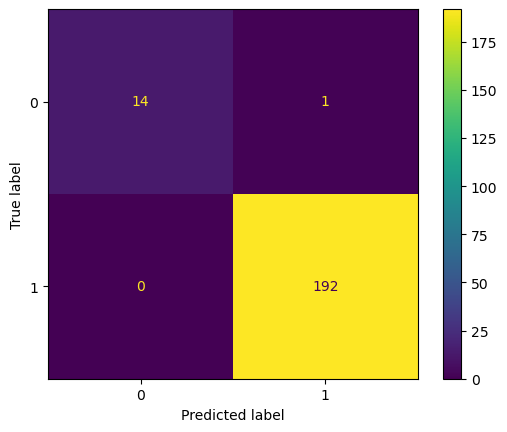

In [78]:
cm = confusion_matrix(y_orig, y_pred)
graph = ConfusionMatrixDisplay(confusion_matrix = cm)
graph.plot()
plt.show()
#reference: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html